[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Singer/surf_tense_mcmc.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Singer/surf_tens_mcmc.ipynb)

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from matplotlib import pylab
import numpy as np
from PySDM.physics import si, Formulae, constants as const, spectra
from atmos_cloud_sim_uj_utils import show_plot
from PySDM_examples.Singer.aerosol import AerosolBetaCary

In [3]:
from PySDM.physics.surface_tension import compressed_film_Ovadnevaite
compressed_film_Ovadnevaite.sgm_org = 40.0 * si.mN / si.m
compressed_film_Ovadnevaite.delta_min = 0.3 * si.nm

In [4]:
formulae_bulk = Formulae(surface_tension='Constant')
formulae_ovad = Formulae(surface_tension='CompressedFilm_Ovadnevaite')

cases = {
    'Beta Caryophyllene': AerosolBetaCary()
}

r_wet = np.logspace(np.log(150 * si.nm), np.log(3000 * si.nm), base=np.e, num=100)
r_dry = 50 * si.nm
v_wet = formulae_ovad.trivia.volume(r_wet)
v_dry = formulae_ovad.trivia.volume(r_dry)
T = 300 * si.K
r_wet_ticks_nm = (300, 500, 700, 1000, 3000)

In [5]:
from importlib import reload
import mcmc
reload(mcmc)
from mcmc import param_transform, get_model, MCMC

params = [0.22, -1.2]
stepsize = [0.01,0.01]
c = AerosolBetaCary()
datax = np.array([200,300,500,700,1000,2000])
args = [T, datax, v_dry, c.aerosol_modes_per_cc['f_org']]
datay = np.array([40,40,50,65,70,72])
errory = 2*np.ones(len(datay))
n_steps = 10000
param_chain, accept_chain, chi2_chain = MCMC(params, stepsize, args, datay, errory, n_steps)

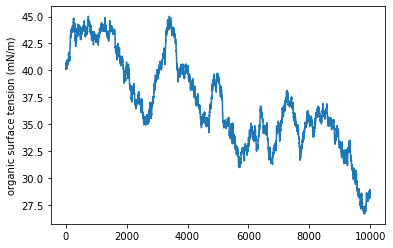

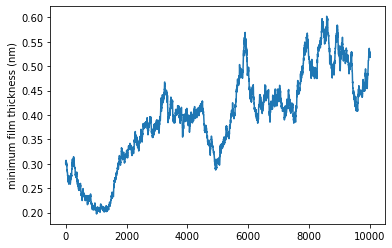

In [6]:
# pylab.plot(param_chain[0,:])
# pylab.show()
# pylab.plot(param_chain[1,:])
# pylab.show()

p = param_transform(param_chain)
pylab.plot(p[0,:])
pylab.ylabel("organic surface tension (mN/m)")
pylab.show()
pylab.plot(p[1,:])
pylab.ylabel("minimum film thickness (nm)")
pylab.show()

### Surface tension

[40.17325676  0.30119421]
[28.53560488  0.52007563]
False
True
True


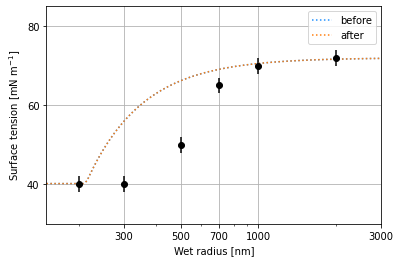

In [7]:
reload(mcmc)
from mcmc import *

# before
p = param_transform(param_chain[:,0])
print(p)

compressed_film_Ovadnevaite.sgm_org = p[0] * si.mN / si.m
compressed_film_Ovadnevaite.delta_min = p[1] * si.nm
formulae_1 = Formulae(surface_tension='CompressedFilm_Ovadnevaite')
sigma = formulae_1.surface_tension.sigma(T, v_wet, v_dry, c.aerosol_modes_per_cc['f_org'])
pylab.plot(r_wet / si.nm, sigma / (si.mN / si.m), label="before", color=c.color, linestyle=":")

# after
p = param_transform(param_chain[:,-1])
print(p)

compressed_film_Ovadnevaite.sgm_org = p[0] * si.mN / si.m
compressed_film_Ovadnevaite.delta_min =  p[1] * si.nm
formulae_2 = Formulae(surface_tension='CompressedFilm_Ovadnevaite')

print(formulae_1 == formulae_2)
print(formulae_1.surface_tension == formulae_2.surface_tension)
print(formulae_1.surface_tension.sigma == formulae_2.surface_tension.sigma)

sigma = formulae_2.surface_tension.sigma(T, v_wet, v_dry, c.aerosol_modes_per_cc['f_org'])
pylab.plot(r_wet / si.nm, sigma / (si.mN / si.m), label="after", color="C1", linestyle=":")
    
pylab.errorbar(datax, datay, yerr=errory, fmt='ko')
pylab.grid()
pylab.xscale('log')
pylab.xticks(r_wet_ticks_nm, r_wet_ticks_nm)
yticks = (20, 40, 60, 80)
pylab.yticks(yticks, yticks)
pylab.xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)
pylab.ylim(30, 85)
pylab.xlabel('Wet radius [nm]')
pylab.ylabel('Surface tension [mN m$^{-1}$]')
pylab.legend()
pylab.savefig("opt_ovad_params.png",dpi=200)
pylab.show()
#show_plot()